## 1 Datenerhebung mittels API & Web Scraping

In [2]:
#import modules
import pandas as pd
import numpy as np
import seaborn as sns
#sns.get_dataset_names()
from pandas_datareader import data
from sklearn.model_selection import train_test_split
import time
import datetime

### 1.1 Yahoo Finance API: Aktienkurs

In [3]:
ticker = 'AAPL'
period1 = int(time.mktime(datetime.datetime(2010, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 2, 1, 23, 59).timetuple()))
interval = '1d'
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
data = pd.read_csv(query_string)
print(data)
data.to_csv('APPL Prices.csv')

            Date        Open        High         Low       Close   Adj Close   
0     2010-01-04    7.622500    7.660714    7.585000    7.643214    6.505280  \
1     2010-01-05    7.664286    7.699643    7.616071    7.656429    6.516526   
2     2010-01-06    7.656429    7.686786    7.526786    7.534643    6.412872   
3     2010-01-07    7.562500    7.571429    7.466071    7.520714    6.401017   
4     2010-01-08    7.510714    7.571429    7.466429    7.570714    6.443573   
...          ...         ...         ...         ...         ...         ...   
3037  2022-01-26  163.500000  164.389999  157.820007  159.690002  158.526505   
3038  2022-01-27  162.449997  163.839996  158.279999  159.220001  158.059921   
3039  2022-01-28  165.710007  170.350006  162.800003  170.330002  169.088974   
3040  2022-01-31  170.160004  175.000000  169.509995  174.779999  173.506546   
3041  2022-02-01  174.009995  174.839996  172.309998  174.610001  173.337784   

         Volume  
0     493729600  
1  

### 1.2 Web Scraping

In [48]:
from pygooglenews import GoogleNews
import json
import time

gn = GoogleNews()
s = gn.search('apple')

for entry in s["entries"]:
    print(entry["title"])


Apple Watch Series 9 Could Gain Long-Awaited Feature, New Leak Claims - Forbes
Apple is reportedly redesigning watchOS around widgets - Engadget
MicroLED Apple Watch Ultra: All the Rumors So Far - MacRumors
Apple releases first ‘rapid’ security fixes for iPhones, iPads and Macs - TechCrunch
Safari is the world's second most-used desktop web browser - 9to5Mac
Apple's Safari Again Overtakes Microsoft Edge as Second Most Popular Desktop Browser - MacRumors
Apple Vs Microsoft: Safari Overtakes Edge As More Popular Web Browser - Microsoft (NASDAQ:MSFT), Alphabet - Benzinga
Apple Pencil 2 Returns to All-Time Low of $89, Original Model Also on Sale - CNET
People Put Nearly $1 Billion Into Apple Savings Accounts in First 4 Days - Yahoo News
A feared tech ‘earnings apocalypse’ hasn’t happened. But Apple and Nvidia could shake things up - Yahoo Finance
A feared tech ‘earnings apocalypse’ hasn’t happened. But Apple and Nvidia could shake things up - Fortune
NYPD asks people to put Apple AirTags i

## 2 Datenaufbereitung

### Entfernen NAs und Duplikate, Erstellen neuer Variablen, Anreicherung der Daten

In [49]:
df = data

# Descriptive Statistics
df.describe()
# Check for format and change it¶
df.info()

# Data cleaning --> Hier noch mehr Befehle suchen
df = data.drop_duplicates()
df['Date'] = pd.to_datetime(df['Date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3042 entries, 0 to 3041
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3042 non-null   object 
 1   Open       3042 non-null   float64
 2   High       3042 non-null   float64
 3   Low        3042 non-null   float64
 4   Close      3042 non-null   float64
 5   Adj Close  3042 non-null   float64
 6   Volume     3042 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 166.5+ KB


## 3 DB - PostgreSQL DB initiate -> In Docker

In [50]:
# Libraries
import os
import fnmatch
import tempfile
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

os.environ['MPLCONFIGDIR'] = "/home/jovyan"
import matplotlib.pyplot as plt

# Settings
import warnings
warnings.filterwarnings("ignore")

# Connect DB
conn = psycopg2.connect("host=db dbname=postgres user=admin password=secret")

# Insert data to appl_prices
engine = create_engine('postgresql://admin:secret@db:5432/postgres')
data.to_sql('appl_prices', engine, if_exists='replace')
cur = conn.cursor()

# Spalte positive hinzufügen
cur.execute("ALTER TABLE appl_prices ADD COLUMN Positive INTEGER DEFAULT 0;")

# Änderungen speichern
conn.commit()

# Datenbankverbindung schliessen
cur.close()
conn.close()

cur.execute("""UPDATE appl_prices SET positive = CASE WHEN "Close" >= "Open" THEN 1 ELSE 0 END;""")

OperationalError: could not translate host name "db" to address: Unknown host


## 4. EDA

In [ ]:
#Daten aus DB lesen und bearbeiten
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Exploratory data analysis
print(df.info())
print(df.describe())

# Plotting
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
plt.title('Apple Stock Price')
plt.xlabel('Year')

plt.ylabel('Price ($)')
sns.lineplot(data=df, x='Date', y='Close')
plt.show()

plt.figure(figsize=(12,6))
plt.title('Daily Change in Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Change in price ($)')
sns.lineplot(data=df, x='Date', y='Close').set(ylabel='Price ($)', xlabel='Year')
sns.lineplot(data=df, x='Date', y=df['Close'].diff()).set(ylabel='Change in price ($)', xlabel='Year')
plt.legend(labels=['Price', 'Daily Change'])
plt.show()

plt.figure(figsize=(12,6))
plt.title('Apple Stock Price Distribution')
sns.histplot(data=df, x='Close', bins=30)
plt.show()

# Split the data into training and test sets
X = df['Open'].values.reshape(-1, 1)
y = df['Close'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'R-squared: {r2:.2f}')
print

### 5. Verwendung eines ML Frameworks/Library & 6. Erstellen von Modellvorhersagen

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pandas_datareader import data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import time
import datetime
import sqlite3

# Fetch data from Yahoo Finance
ticker = 'AAPL'
period1 = int(time.mktime(datetime.datetime(2010, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 2, 1, 23, 59).timetuple()))
interval = '1d'
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
data = pd.read_csv(query_string)

# establish connection to SQLite database
db_file = r"aaplsqlite.db"
with sqlite3.connect(db_file) as conn:
    # write data to a table in the database
    data.to_sql('aapl_prices', conn, if_exists='replace', index=False)

print("Data written to SQLite database successfully!")

# Set up connection to SQLite database
with sqlite3.connect(db_file) as conn:
    # Load data from database table
    df = pd.read_sql_query("SELECT * from aapl_prices", conn)

# Data cleaning
df = df.drop_duplicates()
df['Date'] = pd.to_datetime(df['Date'])

# Plotting
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
sns.lineplot(data=df, x='Date', y='Close')
plt.show()

# Map stock exchange

# Split the data into training and test sets
X = df['Open'].values.reshape(-1, 1)
y = df['Close'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# Train the model
num_epochs = 5000
for epoch in range(num_epochs):
    # Forward pass
    y_pred = net(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Make predictions
X_tensor = torch.from_numpy(X).float()

with torch.no_grad():
    y_pred_tensor = net(X_tensor)
    
y_pred = y_pred_tensor.numpy().flatten()

# Make predictions on test set
X_test_tensor = torch.from_numpy(X_test).float()
with torch.no_grad():
    y_test_pred_tensor = net(X_test_tensor)

y_test_pred = y_test_pred_tensor.numpy().flatten()

# Compute R2-score and MSE on test set
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)

print(f"R2-score on test set: {r2:.4f}")
print(f"MSE on test set: {mse:.4f}")

# Plot predictions against true values
plt.figure(figsize=(12,6))
plt.title('Apple Stock Price Predictions')
plt.xlabel('Open Price ($)')
plt.ylabel('Close Price ($)')
sns.scatterplot(x=X_test.flatten(), y=y_test)
sns.lineplot(x=X_test.flatten(), y=y_test_pred, color='red')
plt.show()

### 7. Evaluation der Modelle mit Hilfe geeigneter Modellgütemasse


In [ ]:
#Das gegebene Python-Skript führt eine Regression durch, um die Schlusskurse von AAPL Aktien anhand der Eröffnungskurse vorherzusagen. Um die Modellevaluation durchzuführen, können wir R2-Score und Mean Squared Error (MSE) verwenden. Der R2-Score misst den Anteil der Varianz in der abhängigen Variable (y) , der durch das Modell erklärt wird, während der MSE den durchschnittlichen quadratischen Fehler zwischen den vorhergesagten Werten und den tatsächlichen Werten berechnet.

#In diesem Skript wird ein neuronales Netzwerk trainiert und validiert, um die Schließkurse vorherzusagen. Es gibt einen Trainings- und einen Testdatensatz. Nachdem das Modell trainiert wurde, werden Vorhersagen auf dem Testdatensatz gemacht, und der R2-Score und MSE werden berechnet. Das Modell wird dann grafisch dargestellt, um Vorhersagen gegen tatsächliche Werte zu vergleichen.

### 8. Korrekte Interpretation der Modellergebnisse und Modellgütemasse

In [ ]:
#Der R2-Score und MSE können wie folgt interpretiert werden:

#Ein R2-Score von 1 bedeutet, dass das Modell alle Variationen in der abhängigen Variable erklärt und perfekt vorhersagt. Ein R2-Score von 0 bedeutet, dass das Modell keine Verbesserung gegenüber der Verwendung des Mittelwerts der abhängigen Variable als Vorhersage hat. Ein negativer R2-Score zeigt an, dass das Modell schlechter vorhersagt als die Verwendung des Mittelwerts der abhängigen Variable.
#Ein kleiner MSE zeigt an, dass das Modell die tatsächlichen Werte besser vorhersagt.
#Im Kontext dieses Skripts zeigt ein hoher R2-Score und ein niedriger MSE, dass das neuronale Netzwerk in der Lage ist, die Schlusskurse von AAPL Aktien basierend auf den Eröffnungskursen mit hoher Genauigkeit vorherzusagen.

## Zusatzpunkte

### Z.1

### Z.2 Docker (siehe Ordner Docker)

### Z.3 Integration und Visualisierung von geographischen Daten

In [ ]:
import yfinance as yf
import folium
import requests
import webbrowser
import os
from bs4 import BeautifulSoup

# Get the Exchange from Yahoo Finance
ticker = yf.Ticker('AAPL').info
market_place = ticker['exchange']
print('Ticker:', ticker)
print('Ticker: AAPL')
print('Market Place:', market_place)

# Yahoo Finance API URL to get exchange symbols for AAPL stock
yahoo_api_url = 'https://finance.yahoo.com/quote/AAPL'

# Nominatim API URL to get geocoding data for exchange locations
nominatim_api_url = 'https://nominatim.openstreetmap.org/search'

# Get exchange symbols for AAPL stock
response = requests.get(yahoo_api_url)
soup = BeautifulSoup(response.content, 'html.parser')
exchange_symbols = market_place
print(exchange_symbols)

# OpenStreetMap URL to get location data for NMS stock exchange
#osm_url = f'https://www.openstreetmap.org/search?query=Cupertino'
osm_url = f'https://nominatim.openstreetmap.org/search.php?q={exchange_symbols}+stock+exchange&format=json'


# Get location data for NMS stock exchange
response = requests.get(osm_url)
location_data = response.json()[0]

# Extract latitude and longitude from location data
lat = float(location_data['lat'])
lon = float(location_data['lon'])

# Create a folium map centered on the NMS stock exchange
m = folium.Map(location=[lat, lon], zoom_start=16)

# Add a marker for the NMS stock exchange
folium.Marker(location=[lat, lon], tooltip='NMS stock exchange').add_to(m)

# Display the map
m
m.save('Exchange.html')
url = 'file://' + os.path.abspath('Exchange.html')
webbrowser.open(url)

### Z.4 CNN

19/19 [==============================] - 3s 31ms/step
6.574273154061214


C:\Users\dangehrn\AppData\Local\Temp\ipykernel_22872\2996318495.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predicted_price


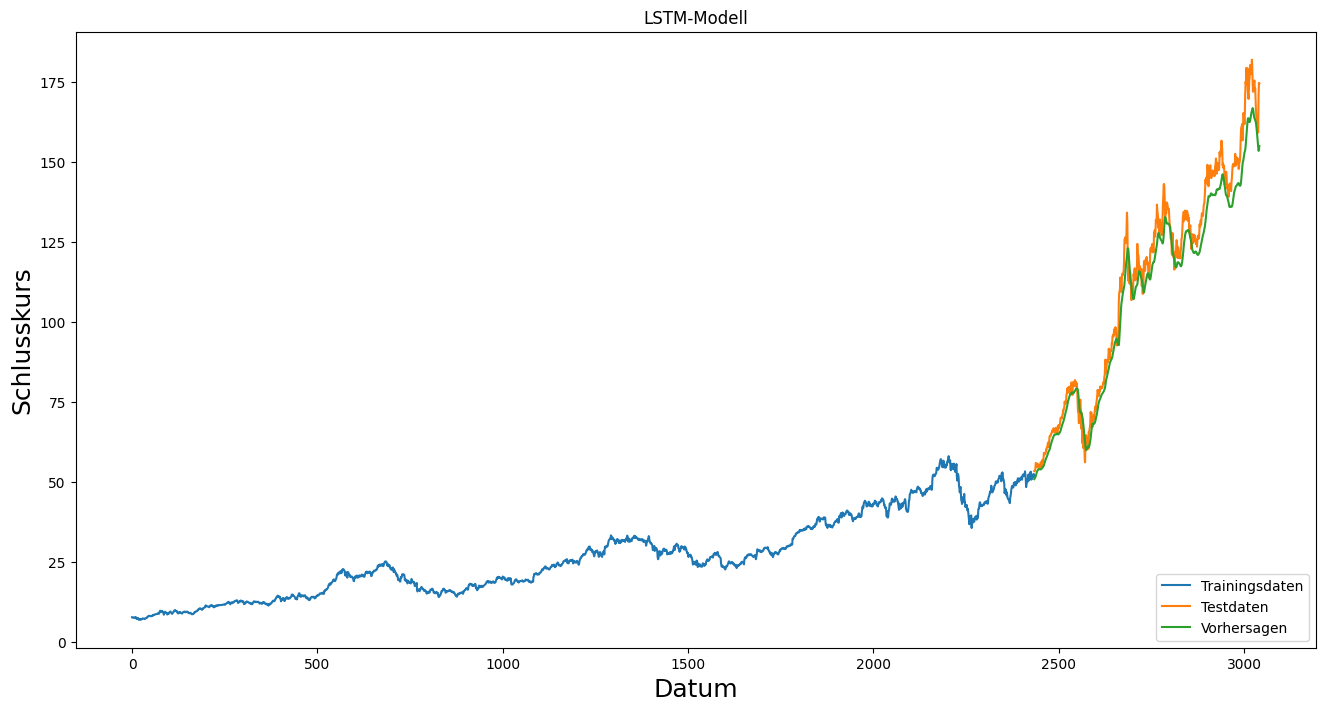

In [4]:
# Bibliotheken importieren
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Daten einlesen
df = pd.read_csv('APPL Prices.csv')

# Datensatz auf die Spalte "Close" reduzieren
data = df.filter(['Close'])

# Datensatz in numpy-Array konvertieren
dataset = data.values

# Anzahl der Datensätze, die für das Training verwendet werden sollen
training_data_len = int(np.ceil( len(dataset) * 0.8 ))

# Skalierung der Daten
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Trainingsdaten erstellen
train_data = scaled_data[0:training_data_len, :]

# Aufteilung der Trainingsdaten in X_train und y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# LSTM-Modell erstellen
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Modell kompilieren
model.compile(optimizer='adam', loss='mean_squared_error')

# Modell trainieren
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Testdaten erstellen
test_data = scaled_data[training_data_len - 60: , :]

X_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

# Konvertierung der Testdaten in numpy-Array
X_test = np.array(X_test)

# Hinzufügen einer zusätzlichen Dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Vorhersage der Testdaten
predicted_price = model.predict(X_test)

# Inverse Skalierung der Vorhersage-Daten
predicted_price = scaler.inverse_transform(predicted_price)

# RMSE berechnen
rmse = np.sqrt(np.mean(((predicted_price - y_test) ** 2)))
print(rmse)

# Plot der Vorhersagen
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predicted_price

plt.figure(figsize=(16,8))
plt.title('LSTM-Modell')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Schlusskurs', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Trainingsdaten', 'Testdaten', 'Vorhersagen'], loc='lower right')
plt.show()